# Assignment 2: Optimal Policies with Dynamic Programming

Welcome to Assignment 2. This notebook will help you understand:
- Policy Evaluation and Policy Improvement.
- Value and Policy Iteration.
- Bellman Equations.

## Gridworld City

Gridworld City, a thriving metropolis with a booming technology industry, has recently experienced an influx of grid-loving software engineers. Unfortunately, the city's street parking system, which charges a fixed rate, is struggling to keep up with the increased demand. To address this, the city council has decided to modify the pricing scheme to better promote social welfare. In general, the city considers social welfare higher when more parking is being used, the exception being that the city prefers that at least one spot is left unoccupied (so that it is available in case someone really needs it). The city council has created a Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences. Now the city has hired you &mdash; an expert in dynamic programming &mdash; to help determine an optimal policy.

## Preliminaries
You'll need two imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- tools: A module containing an environment and a plotting function.

There are also some other lines in the cell below that are used for grading and plotting &mdash; you needn't worry about them.

In this notebook, all cells are locked except those that you are explicitly asked to modify. It is up to you to decide how to implement your solution in these cells, **but please do not import other libraries** &mdash; doing so will break the autograder.

In [217]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import tools

In the city council's parking MDP, states are nonnegative integers indicating how many parking spaces are occupied, actions are nonnegative integers designating the price of street parking, the reward is a real value describing the city's preference for the situation, and time is discretized by hour. As might be expected, charging a high price is likely to decrease occupancy over the hour, while charging a low price is likely to increase it.

For now, let's consider an environment with three parking spaces and three price points. Note that an environment with three parking spaces actually has four states &mdash; zero, one, two, or three spaces could be occupied.

In [218]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

The value function is a one-dimensional array where the $i$-th entry gives the value of $i$ spaces being occupied.

In [219]:
V

array([0., 0., 0., 0.])

In [220]:
state = 0
V[state]

0.0

In [221]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [222]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


The policy is a two-dimensional array where the $(i, j)$-th entry gives the probability of taking action $j$ in state $i$.

In [223]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [224]:
state = 0
pi[state]

array([0.33333333, 0.33333333, 0.33333333])

In [225]:
state = 0
action = 1
pi[state, action]

0.3333333333333333

In [226]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [227]:
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.21    pi(A=2|S=0) = 0.04    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


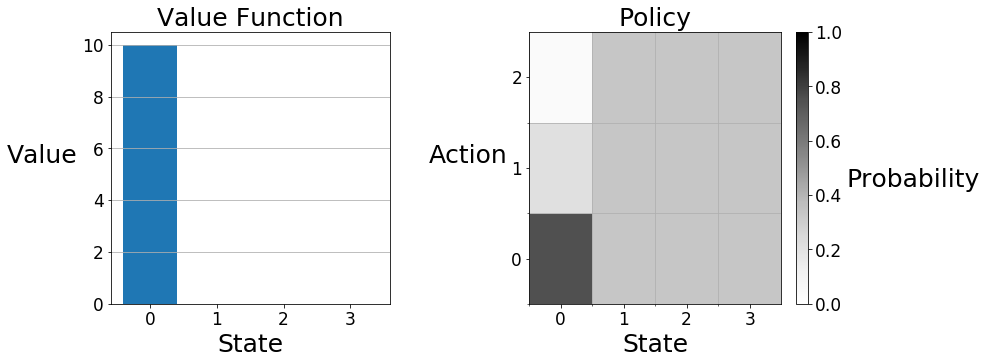

In [228]:
tools.plot(V, pi)

We can visualize a value function and policy with the `plot` function in the `tools` module. On the left, the value function is displayed as a barplot. State zero has an expected return of ten, while the other states have an expected return of zero. On the right, the policy is displayed on a two-dimensional grid. Each vertical strip gives the policy at the labeled state. In state zero, action zero is the darkest because the agent's policy makes this choice with the highest probability. In the other states the agent has the equiprobable policy, so the vertical strips are colored uniformly.

You can access the state space and the action set as attributes of the environment.

In [229]:
env.S

[0, 1, 2, 3]

In [230]:
env.A

[0, 1, 2]

You will need to use the environment's `transitions` method to complete this assignment. The method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [231]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [232]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


## Section 1: Policy Evaluation

You're now ready to begin the assignment! First, the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook. 

We have written an outline of the policy evaluation algorithm described in chapter 4.1 of the textbook. It is left to you to fill in the `bellman_update` function to complete the algorithm.

In [166]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [184]:
# [Graded]
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    ### START CODE HERE ###
    dummy2=0
    for a, v in enumerate(env.A):
        dummy=0
        transitions = env.transitions(s, a)
        for s_, (r, p) in enumerate(transitions):
            dummy= (p * (r+ (gamma*V[s_]))) +dummy 
        dummy2 = (pi[s,a]*dummy) + dummy2
    V[s]=dummy2
    ### END CODE HERE ###

The cell below uses the policy evaluation algorithm to evaluate the city's policy, which charges a constant price of one.

In [185]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

0.0
0.16097941223731776
0.4245770030595378
0.7483001841246648
1.1016896825543332
1.4633532452782991
1.8186793425621293
2.158081812982488
2.475658087501103
2.768168732696969
3.1912683401479534
0.0
0.15877851961555886
0.4187722334904661
0.7380695072249823
1.0866275037321915
1.4433464424468165
1.7938145608440206
2.1285767584333812
2.4418111654440984
2.730322637628645
3.147637674299018
0.0
0.15641512248233636
0.4125388645278324
0.727083440836922
1.0704531979544363
1.4218624227407188
1.7671138698381066
2.0968931766686314
2.4054651312182207
2.689682148536242
3.100785506424715
0.0
0.1538836862873789
0.40586229900834214
0.7153162580372112
1.0531288885954364
1.3988508753656737
1.7385147424664886
2.06295687178879
2.366534870497672
2.646152094436105
3.0506021191716735
0.38666944403986486
0.6331054797258557
1.0668985300483096
1.5404448110756397
2.025078440179119
2.5012197875264874
2.956023278725976
3.381579398557122
3.773547266331707
4.1301207636266595
4.733563228974617
0.41749592780148503
0.68357

14.576553266955097
19.7727425308794
24.32107348978238
28.276886069799357
31.69673510591309
34.636152115403135
37.147810766227366
39.280828187722854
46.103741707363824
4.3765618902281185
9.373952658273396
15.132960975927922
20.209502032387988
24.653102463100808
28.517827929037946
31.858931025351115
34.73066459255065
37.184489427078084
39.26839168012815
45.934199803709696
4.7168162050514715
10.102727417759573
15.718818429584804
20.669378495794003
25.002705183752788
28.771522444510158
32.02971170797485
34.830179459630145
37.22310942910718
39.25529692864586
45.75568432601021
5.073734541285508
10.86719406318685
16.333368366264025
21.151777498661268
25.369429765813656
29.03764169834256
32.20885640782863
34.93456808672812
37.26362085326574
39.241560859156564
45.568426017983775
3.24690461446073
7.517120875665653
12.429971107455469
18.383671102868863
23.58756159556981
28.1079954386452
32.01189655913306
35.36439575670074
38.226892788877606
40.65636964241181
48.45580080189633
3.481192425165573
8.

5.780431854884576
8.33566951550687
11.577166477644244
15.677537601045413
20.84854854371511
27.347384162281394
35.483584912860515
71.18716259424016
1.0136909297800858
2.3114496172124426
3.9698366046051143
6.084398517410541
8.774004523367394
12.185957091228474
16.501948112379132
21.94487903915873
28.785458911938683
37.3495055138109
71.35426087643367
1.0643332813414408
2.426925883885389
4.168163190219492
6.388365179936505
9.212339531227915
12.794747704812698
17.326358623712842
23.041209534602334
30.22353366159595
39.21542611476126
71.52135915862712
7.271492575827874
16.60652878373007
24.623164916599904
31.490836544434586
37.35846880632171
42.35730713850705
46.603009807963836
50.19735147924807
53.22922478163271
55.776298756638475
64.331598712366
7.926371517165865
17.1337801481731
25.04081372335594
31.81459130844134
37.602001954577105
42.53249672500032
46.72015261972038
50.26535285139774
53.25577471916359
55.76802538204047
64.20635822819912
8.629603922629183
17.699961501544365
25.4892999342

36.96793531381381
45.49265578424148
52.66823557844455
58.69083928777417
63.72904791147634
81.0167256788482
3.3820431121940864
7.667105272642592
13.093734676037814
19.958441951896084
28.62905346195633
38.37045764583932
46.59035280269944
53.50934959592498
59.31659820117135
64.17465153076549
80.8441598444204
2.3547067186874067
5.336614061458706
9.111093323847179
13.883662563813704
19.90923231429224
27.502987117635303
36.915791409870884
46.21067223053707
54.00986384729423
60.53273029984276
82.94842512252656
2.4826134054823403
5.626496711339168
9.606004112899647
14.637817323310106
20.990693509328565
28.996937906182517
38.92104180142773
47.78824479202982
55.22857851579576
61.451313592369985
82.83561318728182
2.6235280250487407
5.945860024942126
10.151246643264354
15.468668576607019
22.182137809021
30.64282141934529
40.719006465920806
49.19779519875602
56.312216489490105
62.262374178515046
82.7099672534763
2.7857643840770003
6.313546084526097
10.778989621146383
16.425235628654022
23.553859109

66.16159742686582
86.89188883694635
2.078221848559976
4.700432439379734
8.008952098336332
12.180378790286873
17.43350772384364
24.038646709743528
32.32851198429225
42.650511137887015
52.39768544716449
60.536788448485524
88.71135183216585
2.1847973363225086
4.941480275667682
8.419667622734456
12.805013648979518
18.327533831002473
25.27139791963832
33.98638452362205
44.83771700861311
54.10961267074503
61.851847642347515
88.65260073557609
2.3128100657028114
5.23101393938585
8.91299696497698
13.555291361106828
19.401389785287712
26.7521122033686
35.97773162584824
46.58169754027197
55.46282082347313
62.8787523412468
88.54996359912552
2.448113831639795
5.537038154760703
9.434424155661501
14.348301559708457
20.536407805698772
28.317161396798415
38.082497015378046
48.238679923653486
56.7447721935697
63.84754464093354
88.43471505585889
1.7388575411433078
3.9319631389493352
6.69795807312606
10.184036709489659
14.572541128795972
20.088720441528423
27.009809989275894
35.67551602882344
46.438066783

57.93167288522564
65.17928943318164
90.3279999593818
1.7814472021497612
4.025444243801886
6.852509246002047
10.412079854870521
14.889202538399699
20.512400268652534
27.562880604876078
36.38517602517794
47.37102224536187
57.30098572125483
91.80037509178432
1.8721382700959057
4.230374166500411
7.201361224820621
10.94214475965088
15.647191704424056
21.556658826670972
28.96606958219282
38.237496131633975
49.55400821776264
58.99642505766056
91.80194503256547
1.9809049643588073
4.4761486485112165
7.619742851396019
11.577856839609794
16.556255603908845
22.809048437727892
30.648927993117184
40.45900194536601
51.29350166320665
60.33373082648459
91.74194160791401
2.0908168213302734
4.724510795555172
8.042529457270913
12.22026208765924
17.47489068770191
24.074623977518748
32.34950457327566
42.703897139753465
53.051309566389904
61.68511657362169
91.68130643027268
1.4971483343026784
3.3823132025167366
5.7564307790721365
8.744640860447694
12.501883328052447
17.219482517084998
23.13285615323393
30.53

4.522064527884131
7.695655015909661
11.689866657754495
16.71179278018793
23.017150726031534
30.9205842139932
40.807571453989276
51.7393467086831
60.85858553829113
92.5731056318771
2.1128966448597697
4.772974348671734
8.122653659776553
12.338486846617775
17.639057949815765
24.29427296258927
32.636233824020124
43.07180726423954
53.512122005247264
62.22138663622721
92.51011503785448
1.5127612082971211
3.4165822874630467
5.813087440116307
8.828238823183996
12.61796771495763
17.37479861018384
23.335605403308953
30.790580868482955
40.09212229304748
51.653355485175396
93.55180981654931
1.5930081383308754
3.5978205676839146
6.121452315239077
9.296547409681134
13.287308762861807
18.29647365101299
24.57348133760965
32.42391835433322
42.21887548774139
53.684404756168014
93.60676127731196
1.681097730463404
3.7967715577933383
6.459954187723628
9.810624550817137
14.022065592595187
19.308225482406666
25.932336886567757
34.21688455108115
44.55347970759547
55.50160166033031
93.62237372426321
1.76964245

You can use the ``plot`` function to visualize the final value function and policy.

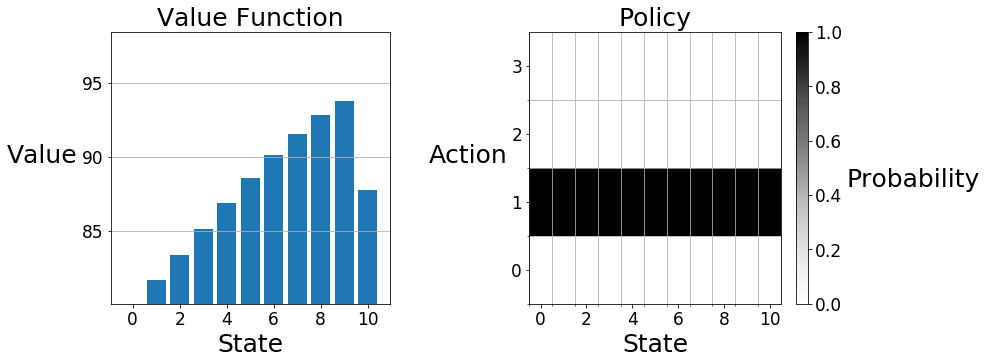

In [169]:
tools.plot(V, city_policy)

You can check the output (rounded to one decimal place) against the answer below:<br>
State $\quad\quad$    Value<br>
0 $\quad\quad\quad\;$        80.0<br>
1 $\quad\quad\quad\;$        81.7<br>
2 $\quad\quad\quad\;$        83.4<br>
3 $\quad\quad\quad\;$        85.1<br>
4 $\quad\quad\quad\;$        86.9<br>
5 $\quad\quad\quad\;$        88.6<br>
6 $\quad\quad\quad\;$        90.1<br>
7 $\quad\quad\quad\;$        91.6<br>
8 $\quad\quad\quad\;$        92.8<br>
9 $\quad\quad\quad\;$        93.8<br>
10 $\quad\quad\;\;\,\,$       87.8<br>

Observe that the value function qualitatively resembles the city council's preferences &mdash; it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [144]:
## Test Code for bellman_update() ## 
with open('section1', 'rb') as handle:
    V_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)

## Section 2: Policy Iteration
Now the city council would like you to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. We have written an outline of the policy iteration algorithm described in chapter 4.3 of the textbook. We will make use of the policy evaluation algorithm you completed in section 1. It is left to you to fill in the `q_greedify_policy` function, such that it modifies the policy at $s$ to be greedy with respect to the q-values at $s$, to complete the policy improvement algorithm.

In [233]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [243]:
du=np.array(env.A)+0.0
du
np.zeros(len(env.A))

array([0., 0., 0., 0.])

In [244]:
# [Graded]
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    ### START CODE HERE ###
    dummy2=np.array(env.A)+0.0
    for a, v in enumerate(env.A):
        dummy=0
        transitions = env.transitions(s, a)
        for s_, (r, p) in enumerate(transitions):
            dummy= (p * (r+ (gamma*V[s_]))) + dummy
        dummy2[a] =dummy
    
    index = np.argmax(dummy2)
    update=np.zeros(len(env.A))
    update[index]=1
    pi[s]=update
    ### END CODE HERE ###

When you are ready to test the policy iteration algorithm, run the cell below.

In [245]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

0.0
0.16097941223731776
0.4245770030595378
0.7483001841246648
1.1016896825543332
1.4633532452782991
1.8186793425621293
2.158081812982488
2.475658087501103
2.768168732696969
3.1912683401479534
0.0
0.15877851961555886
0.4187722334904661
0.7380695072249823
1.0866275037321915
1.4433464424468165
1.7938145608440206
2.1285767584333812
2.4418111654440984
2.730322637628645
3.147637674299018
0.0
0.15641512248233636
0.4125388645278324
0.727083440836922
1.0704531979544363
1.4218624227407188
1.7671138698381066
2.0968931766686314
2.4054651312182207
2.689682148536242
3.100785506424715
0.0
0.1538836862873789
0.40586229900834214
0.7153162580372112
1.0531288885954364
1.3988508753656737
1.7385147424664886
2.06295687178879
2.366534870497672
2.646152094436105
3.0506021191716735
0.3843937556567463
0.6308297913427372
1.064622841665191
1.5381691226925212
2.0228027517960006
2.498944099143369
2.9537475903428576
3.3793037101740033
3.7712715779485886
4.127845075243541
4.731287540591499
0.4150388145034423
0.681121

3.360343372669756
5.273750080944496
7.776286886868583
11.027628217990593
15.225788559614816
20.614207271825293
26.502452486907618
31.541486449141612
47.30197635627776
0.862058635830151
2.018854021792722
3.555571175055748
5.580142173791172
8.228070300430932
11.668306679613877
16.110369958129983
21.81184273263548
27.4492856687487
32.273688419922756
47.36288040348491
0.9098905445724516
2.130871507983118
3.7528544559177814
5.889760151191064
8.684610367866657
12.315730598450914
17.00426477411301
23.02208763678187
28.40608769315159
33.01359946375938
47.424425685990535
0.6621030210502669
1.548323753742264
2.7231567502391263
4.26827677521772
6.286184238515931
8.904646105633818
12.282076703897507
16.61321456167254
22.13558426428405
28.30519684264524
48.480904541681866
0.6972253751362546
1.6304571580460532
2.8676111214966857
4.494694603667433
6.619645318824386
9.377007843292677
12.93359985541746
17.49449011213896
23.309803084788996
29.42834359136912
48.652484640987566
0.735780293621828
1.7206175

46.79067431988948
49.99770245630985
52.69932032742848
61.71400065941067
3.445106993466262
7.8723154015573416
13.549293137759296
20.421956642471788
28.221926846758677
34.89001586308913
40.570699806791424
45.39262884047196
49.46989904761577
52.90329961945853
64.38560899030117
3.673606880481682
8.394453954356171
14.447962455428812
21.77646168231194
29.302275345488866
35.73599164337922
41.217008585752666
45.86945448671238
49.80341513396237
53.11613713904547
64.19486160653364
3.9081513526396088
8.930404815685224
15.37040457787545
23.16679790415489
30.41120267009704
36.604346308399855
41.880414390422786
46.35889376377107
50.14575383465092
53.33460492184815
63.99906831741819
4.159073669288543
9.503780220773116
16.35725927630134
24.489928147758413
31.46580006504361
37.42937860351191
42.509875394649164
46.822348192905125
50.46883837072221
53.53948633508819
63.808643445665226
2.8163783779871205
6.4324267331564435
11.065523086378828
16.987563979560147
24.160589739883203
31.950906027546342
38.5837

2.4340365679064533
4.164641055536011
6.360351175572554
9.141342812358177
12.656318338691836
17.088493864741665
22.662533883372422
29.65213219427921
38.38825337355492
77.8346997738874
1.1280872943940174
2.5620314981446644
4.38364061716914
6.694813161781801
9.622044520368146
13.321856648260777
17.987100158884147
23.854253630589806
31.21140317716563
40.406917298863604
77.9764508548152
1.1844447024325735
2.690026428382873
4.602640178802268
7.029275147991045
10.102746228378109
13.98739495782971
18.885706453026614
25.04597337780717
32.770674160052025
42.42558122417227
78.11820193574297
8.141669043752886
18.51262481057052
27.361515849197836
34.90118322414688
41.31323603272548
46.75415816170114
51.35939954283202
55.24648123512726
58.517300374476626
61.26017033644286
70.58298105151104
8.874917073438203
19.104082286354895
27.83199227077788
35.26857815185503
41.59296608751234
46.95950053421983
51.501779567331894
55.335717511008305
58.56181837482881
61.2671881237067
70.46253840745835
9.66230500602

4.525515104591494
7.712562487857789
11.732822269546652
16.79823712740638
23.17065844415056
31.17233230197234
41.19820595311823
51.17788927719622
59.5174956732545
88.39520480037336
1.433345455995123
3.2416012695475946
5.523107686208959
8.399967070374178
12.023414523232873
16.580279040257267
22.300465336474986
29.46573779864221
38.41935028414814
49.494679759670504
89.46270185590538
1.509379645588679
3.4135573911403316
5.816090103812738
8.845557270654993
12.661216509905179
17.459807471305147
23.48343054721749
31.02879678412632
40.45736851021361
51.44101637448591
89.52398752542967
1.5928447793527545
3.602319062264998
6.137706166356974
9.334695720991697
13.361351915005994
18.425293636662254
24.78200885890423
32.744616049143204
42.694565549617494
53.182552060200116
89.54694507877288
1.6767411511236123
3.7920560053762022
6.460983917602898
9.8263613953422
14.065104698800848
19.395768164354003
26.087296514930674
34.469300410835494
44.94332148012407
54.93308571122006
89.57002124654949
1.10668468

6.033571051642523
10.277594028998452
15.627823520552003
22.365445039343875
30.837792359260888
41.4343191923187
50.88264336061142
58.79725271992913
65.40869748941552
88.3172403672681
2.820167022821444
6.376040147914832
10.860956404089169
16.514868116857798
23.634921056911775
32.58816387057908
43.34707634750808
52.3815311341189
59.949453141960355
66.27129369063117
88.17636290403144
2.994563341544061
6.77032811767894
11.532587126437313
17.536131106057663
25.096481025619358
34.60338345401799
44.94045685836402
53.62068569168738
60.891882058529916
66.9658537487276
88.01206161330092
2.1064439037875946
4.761325169072171
8.108518114440407
12.326560081053898
17.636515682534675
24.311426848261885
32.68722279283003
43.1398528223076
53.00972648847653
61.252797330919364
89.85174372594737
2.214466676546976
5.005495709691546
8.524339588782334
12.958691416783413
18.540952455057344
25.558166784304788
34.363490759679806
45.35215314035452
54.740765257821124
62.58189853005017
89.7863414391315
2.34421780662

69.07136137120797
79.14613578885826
12.096203260026622
23.416710732249555
33.00634160523515
41.1253276280463
47.99124532412532
53.78826245473317
58.67323997228604
62.78040756051804
66.22469509140323
69.10461027574641
79.01633365196207
7.292004671841159
16.4797994837386
27.630397988541226
37.06692912757481
45.04385632508435
51.77643857461247
57.44788975880576
62.214872577867574
66.21142670643005
69.55235714791361
81.067278866344
7.873345833060494
17.793620058420082
28.687463265159252
37.90670746984181
45.699956785007636
52.27751361940043
57.81837314623804
62.47559072767208
66.38011962135018
69.64412131403672
80.893898775258
8.485456425573025
19.176978994740118
29.80047726788002
38.79093389823725
46.39078356291722
52.80510974198543
58.20846560988116
62.75010826023566
66.5577411747386
69.74074240651053
80.71134196118007
9.127545253702143
20.628088204691412
30.968001348397635
39.718465488368345
47.11544371697119
53.35854498754386
58.6176629279908
63.03807034248155
66.74406177833659
69.8420

3.122710653553996
7.057457714957896
12.017575504328637
18.267735981840055
26.13562484826611
36.01771995648827
46.17057447997261
54.6931442833575
61.83010140762987
67.7903623336726
88.45608432550775
3.302932125632175
7.4647658390941
12.711147656374113
19.32202459049991
27.643994116637757
38.09641607393684
47.81329115270718
55.969888485805875
62.80037351429567
68.50469151878113
88.28299510254458
3.484918098881954
7.876061810260698
13.411510391476982
20.386635462449107
29.16713143295926
40.1954641599513
49.47209123359629
57.259132955925324
63.78014530071239
69.22601451361442
88.10821120839051
3.7137114374037665
8.393144400107447
14.292008627022442
21.725067602411688
31.082024462380005
41.71600819068117
50.660923419183256
58.16951760261563
64.45735284327674
69.70848971319703
87.91550045339594
2.5823676517652934
5.834975625244475
9.933602273387725
15.096294622486916
21.59297967369535
29.75700599677414
39.99031633308273
50.06821998309863
58.50566121435645
65.55056760641187
90.00816342825414


9.397753165762698
13.430394623102018
18.489474044295633
24.82497051704908
32.74271603134505
42.61490147903571
54.16393902628681
94.4964242602667
1.6987401075378574
3.8376559835388937
6.530310929500934
9.917426746464935
14.173063763366148
19.511898342148573
26.197732824365477
34.55331098758582
44.971405001980315
55.99926673813283
94.51165955147248
1.7882140684984316
4.039788305091572
6.874267478577442
10.439785316563501
14.919570040711397
20.539605183698605
27.5775877613165
36.373260716589854
47.34008383497812
57.84407700908534
94.52697355862013
1.1861360914172125
2.6829566015333057
4.571332846874736
6.951553299318826
9.94774794127073
13.713089009862722
18.435858979587707
24.346427887689316
31.725098952220645
40.91777533568806
88.38803573980886
1.2516256815081257
2.831089458578562
4.823727758788474
7.335366235592925
10.496988403402824
14.470223528097552
19.453749638411274
25.690656087201983
33.47672234603557
43.176949770692865
88.50135469686943
1.31744299251376
2.979963597335061
5.07738

7.502584775410524
16.96411933859856
28.439657541694572
38.14122607645645
46.331946404172754
53.23540574156546
59.042382026699414
63.91600382092645
67.99587758360079
71.40403324856568
83.19785141213508
8.100714033655008
18.316551389752775
29.527852186174563
39.006030997079634
47.00815061083503
53.75264989248922
59.42591389964142
64.18731497173535
68.17324496954849
71.50292394797249
83.02517594434563
8.730501289549961
19.740565444475127
30.673643182987007
39.9166086194522
47.72014519372564
54.29727092539784
59.82974548366612
64.47298617541986
68.36000011944553
71.60704876941281
82.84336104811621
9.391132499097225
21.234320865179356
31.875549517272734
40.871781958423355
48.46700985013683
54.86856487958247
60.25335479825686
64.77264818200453
68.555901639222
71.71627312428527
82.652641731894
5.9427026356485495
13.442710220229715
22.89539794721621
33.89628842048535
43.1805974159997
51.00315828358714
57.58125955380957
63.10056855470213
67.71987226262151
71.57783387037976
84.94596437279446
6.3

In [246]:
print(V)

[81.60940117 83.28357754 85.03018628 86.79007707 88.51662023 90.16819235
 91.70422113 93.0826894  94.25817123 95.25809638 89.45397249]


You can use the ``plot`` function to visualize the final value function and policy.

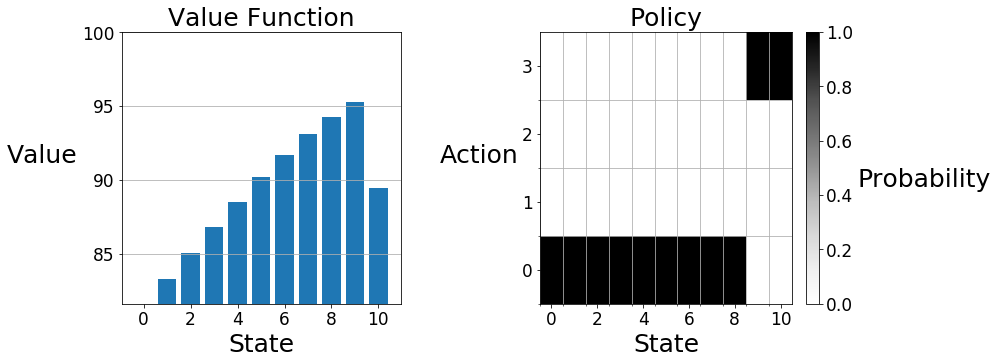

In [247]:
tools.plot(V, pi)

You can check the value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [248]:
## Test Code for q_greedify_policy() ##
with open('section2', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

## Section 3: Value Iteration
The city has also heard about value iteration and would like you to implement it. Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
We have written an outline of the value iteration algorithm described in chapter 4.4 of the textbook. It is left to you to fill in the `bellman_optimality_update` function to complete the value iteration algorithm.

In [249]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [250]:
# [Graded]
def bellman_optimality_update(env, V, s, gamma):
    """Mutate ``V`` according to the Bellman optimality update equation."""
    ### START CODE HERE ###
    dummy2=np.array(env.A)+0.0
    for a, v in enumerate(env.A):
        dummy=0
        transitions = env.transitions(s, a)
        for s_, (r, p) in enumerate(transitions):
            dummy= (p * (r+ (gamma*V[s_]))) + dummy
        dummy2[a] =dummy
    
    index = np.argmax(dummy2)
    V[s]=dummy2[index]
    ### END CODE HERE ###

When you are ready to test the value iteration algorithm, run the cell below.

In [251]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

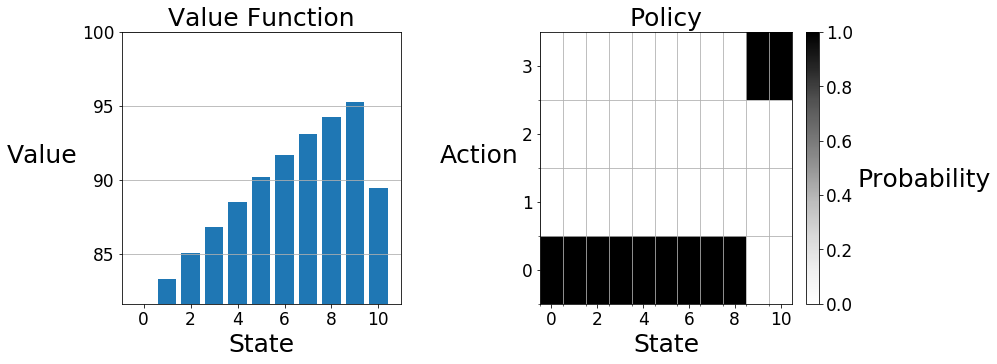

In [252]:
tools.plot(V, pi)

In [253]:
print(V)

[81.60486891 83.27914232 85.02582907 86.78578527 88.512385   90.16400718
 91.70008103 93.07859042 94.25411015 95.25410254 89.45001308]


You can check your value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [254]:
## Test Code for bellman_optimality_update() ## 
with open('section3', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations. 

In [255]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

You can try the second value iteration algorithm by running the cell below.

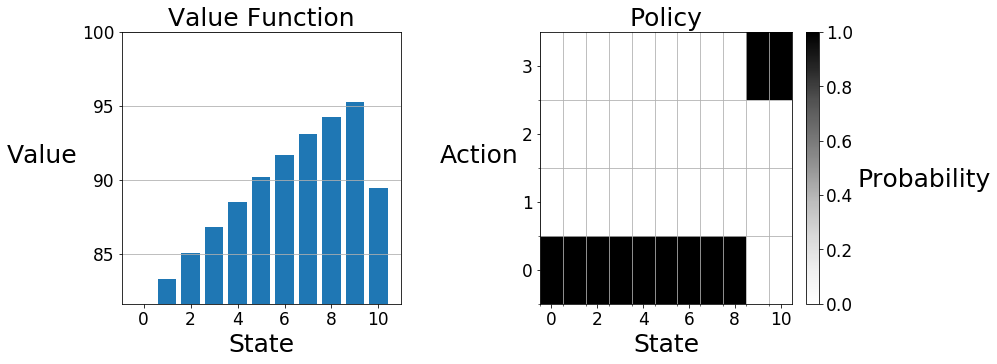

In [256]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

## Wrapping Up
Congratulations, you've completed assignment 2! In this assignment, we investigated policy evaluation and policy improvement, policy iteration and value iteration, and Bellman updates. Gridworld City thanks you for your service!